**Packages**

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy

2023-03-15 20:27:43.776099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 20:27:43.908764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 20:27:43.908788: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 20:27:44.700605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [3]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [4]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [1]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
x_train = tiles_train.drop(['bin_numeric'], axis = 1)
y_train = tiles_train['bin_numeric']
x_train.head(5)

NameError: name 'pd' is not defined

In [ ]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['bin_numeric'], axis = 1)
y_test = tiles_test['bin_numeric']
x_test.head(5)

Image Pre-Processing

In [7]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [8]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(8376, 148, 188, 4)

In [9]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [10]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [11]:
street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [12]:
street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 11)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.1: CNN (layers added, ResNet-18)**

In [13]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

2023-03-15 18:32:18.493716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 18:32:18.493751: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 18:32:18.493776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-15 18:32:18.496020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 71, 91, 11)   0           ['conv2d[0][0]']                 
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 avgpool (GlobalAveragePooling2  (None, 512)         0           ['layer4.1.relu2[0][0]']         
 D)                                                                                               
                                                                                                  
 fc (Dense)                     (None, 1000)         513000      ['avgpool[0][0]']                
                                                                                                  
 output (Dense)                 (None, 12)           12012       ['fc[0][0]']                     
                                                                                                  
Total params: 11,736,927
Trainable params: 11,727,327
Non-trainable params: 9,600
__________________________________________________________________________________________________


2023-03-15 18:32:19.499961: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
210/210 [==============================] - 126s 570ms/step - loss: 456.9090 - accuracy: 0.4196 - val_loss: 2.1980 - val_accuracy: 0.1313
Epoch 2/10
210/210 [==============================] - 118s 563ms/step - loss: 326.4388 - accuracy: 0.5539 - val_loss: 1.6998 - val_accuracy: 0.2100
Epoch 3/10
210/210 [==============================] - 118s 564ms/step - loss: 320.6008 - accuracy: 0.5304 - val_loss: 1.4240 - val_accuracy: 0.4851
Epoch 4/10
210/210 [==============================] - 116s 552ms/step - loss: 308.2407 - accuracy: 0.5869 - val_loss: 0.7821 - val_accuracy: 0.6492
Epoch 5/10
210/210 [==============================] - 119s 566ms/step - loss: 295.4814 - accuracy: 0.5945 - val_loss: 1.8615 - val_accuracy: 0.1337
Epoch 6/10
210/210 [==============================] - 123s 587ms/step - loss: 295.3576 - accuracy: 0.6030 - val_loss: 1.6101 - val_accuracy: 0.1504
Epoch 7/10
210/210 [==============================] - 117s 555ms/step - loss: 291.9565 - accuracy: 0.6018 - val_

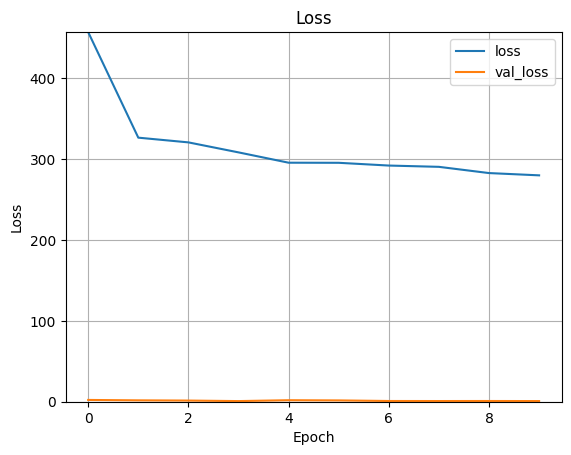

In [14]:
plot_loss(history)

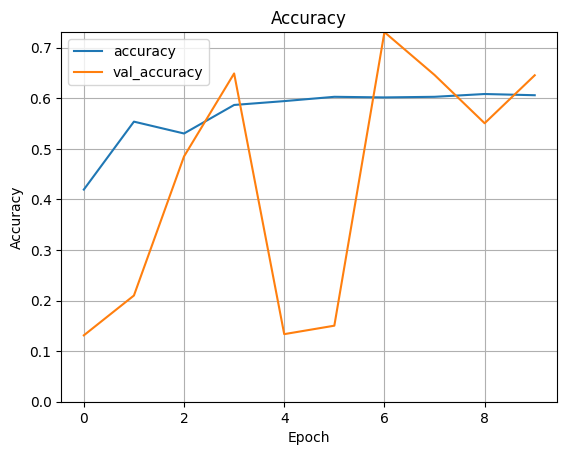

In [15]:
plot_accuracy(history)

In [16]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

66/66 [==============================] - 6s 84ms/step
macro f1:  0.1745970165588644
f1 by class:  [0.78165939 0.43859649 0.         0.24       0.         0.28571429
 0.         0.         0.         0.        ]


**Model 2.2: Second CNN (layers added, ResNet-34)**

In [17]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet34(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight, 
    )


/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_1[0][0]']               
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


                                                                  'layer3.1.bn2[0][0]']           
                                                                                                  
 layer3.1.relu2 (ReLU)          (None, 5, 6, 256)    0           ['layer3.1.add[0][0]']           
                                                                                                  
 layer3.2.conv1_pad (ZeroPaddin  (None, 7, 8, 256)   0           ['layer3.1.relu2[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer3.2.conv1 (Conv2D)        (None, 5, 6, 256)    589824      ['layer3.2.conv1_pad[0][0]']     
                                                                                                  
 layer3.2.bn1 (BatchNormalizati  (None, 5, 6, 256)   1024        ['layer3.2.conv1[0][0]']         
 on)      

2023-03-15 18:52:26.343724: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - 211s 953ms/step - loss: 533.8474 - accuracy: 0.3600 - val_loss: 3.4808 - val_accuracy: 0.7864
Epoch 2/10
210/210 [==============================] - 197s 938ms/step - loss: 358.3877 - accuracy: 0.4455 - val_loss: 1.0246 - val_accuracy: 0.8055
Epoch 3/10
210/210 [==============================] - 194s 922ms/step - loss: 334.8110 - accuracy: 0.4869 - val_loss: 1.2035 - val_accuracy: 0.4326
Epoch 4/10
210/210 [==============================] - 193s 921ms/step - loss: 314.5153 - accuracy: 0.5548 - val_loss: 0.9033 - val_accuracy: 0.4797
Epoch 5/10
210/210 [==============================] - 189s 902ms/step - loss: 309.5943 - accuracy: 0.5549 - val_loss: 1.0260 - val_accuracy: 0.4869
Epoch 6/10
210/210 [==============================] - 182s 869ms/step - loss: 314.0700 - accuracy: 0.5633 - val_loss: 1.3407 - val_accuracy: 0.1778
Epoch 7/10
210/210 [==============================] - 180s 859ms/step - loss: 320.5569 - accuracy: 0.5230 - val_loss: 2.668

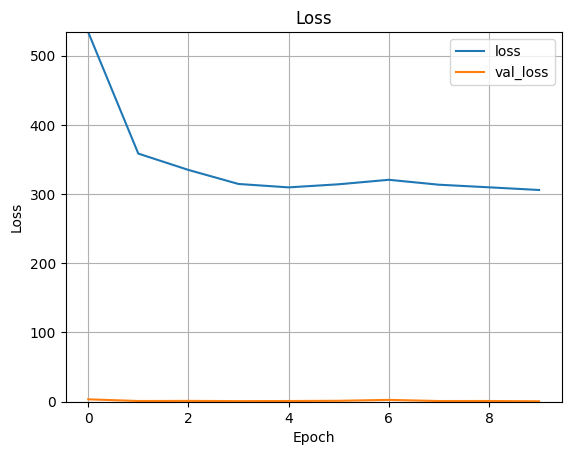

In [18]:
plot_loss(history)

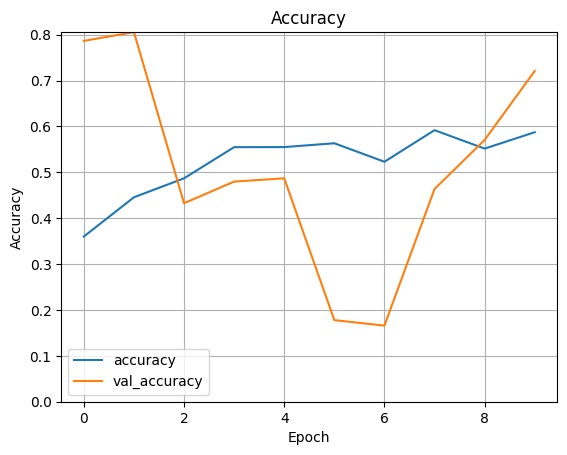

In [19]:
plot_accuracy(history)

In [20]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
predicted_result[0]

66/66 [==============================] - 36s 534ms/step


array([9.10551488e-01, 7.63433427e-02, 1.16566420e-02, 9.19420854e-04,
       1.10132925e-04, 1.02327729e-04, 8.70814474e-05, 8.13020015e-05,
       4.86419995e-05, 5.35126310e-05, 1.48504569e-05, 3.12342490e-05],
      dtype=float32)

In [21]:
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
test_values[0:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

macro f1:  0.142832157478533
f1 by class:  [0.84797862 0.45436893 0.02597403 0.1        0.         0.
 0.         0.         0.         0.        ]


**Model 2.3: CNN (layers concatenated, ResNet-18)**

In [13]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(71): 
        for j in range(91):
            street_mini_2.append(street[k])

In [14]:
street_mini_2 = np.reshape(street_mini_2, (len(street),71,91,11))
np.shape(street_mini_2)

(8376, 71, 91, 11)

In [15]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(71,91,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    combined = tf.keras.layers.Concatenate(axis = 3)([images.output, input2])
    #combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(resnet)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini_2],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight,
    )

2023-03-15 20:29:30.296163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 20:29:30.296200: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 20:29:30.296224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-15 20:29:30.296430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initialize

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 71, 91, 11)   0           ['conv2d[0][0]']                 
                                                                                            

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 layer2.1.relu2 (ReLU)          (None, 9, 12, 128)   0           ['layer2.1.add[0][0]']           
                                                                                                  
 layer3.0.conv1_pad (ZeroPaddin  (None, 11, 14, 128)  0          ['layer2.1.relu2[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer3.0.conv1 (Conv2D)        (None, 5, 6, 256)    294912      ['layer3.0.conv1_pad[0][0]']     
                                                                                                  
 layer3.0.bn1 (BatchNormalizati  (None, 5, 6, 256)   1024        ['layer3.0.conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 layer3.0.

2023-03-15 20:29:31.643474: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


Epoch 1/10
210/210 [==============================] - 396s 2s/step - loss: 479.3481 - accuracy: 0.4199 - val_loss: 1.5527 - val_accuracy: 0.7691
Epoch 2/10
210/210 [==============================] - 522s 2s/step - loss: 352.5001 - accuracy: 0.4899 - val_loss: 1.2673 - val_accuracy: 0.4696
Epoch 3/10
210/210 [==============================] - 386s 2s/step - loss: 317.3802 - accuracy: 0.5593 - val_loss: 1.1586 - val_accuracy: 0.4409
Epoch 4/10
210/210 [==============================] - 517s 2s/step - loss: 302.4932 - accuracy: 0.5739 - val_loss: 1.0224 - val_accuracy: 0.5364
Epoch 5/10
210/210 [==============================] - 384s 2s/step - loss: 301.6355 - accuracy: 0.5934 - val_loss: 0.6467 - val_accuracy: 0.7005
Epoch 6/10
210/210 [==============================] - 516s 2s/step - loss: 291.1473 - accuracy: 0.5940 - val_loss: 1.5085 - val_accuracy: 0.1378
Epoch 7/10
210/210 [==============================] - 380s 2s/step - loss: 292.7673 - accuracy: 0.5999 - val_loss: 1.1221 - val_ac

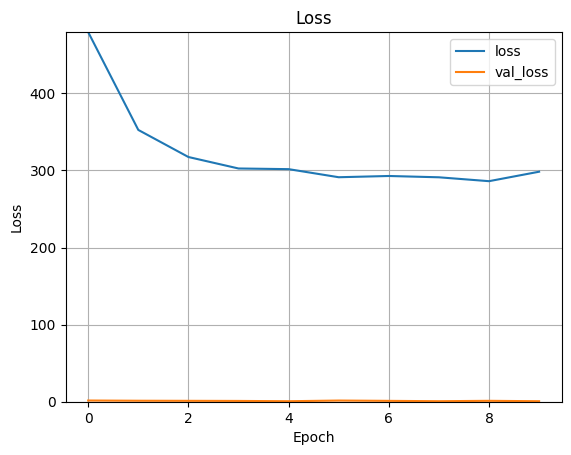

In [16]:
plot_loss(history)

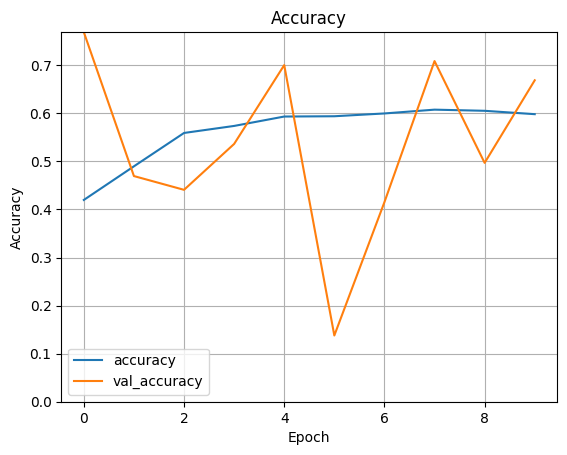

In [17]:
plot_accuracy(history)

In [20]:
street_mini_2_t = [] 
for k in range(len(street_t)):
    for i in range(71): 
        for j in range(91):
            street_mini_2_t.append(street_t[k])
street_mini_2_t = np.reshape(street_mini_2_t, (len(street_t),71,91,11))
np.shape(street_mini_2_t)

(2095, 71, 91, 11)

In [22]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_2_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

66/66 [==============================] - 6s 89ms/step
macro f1:  0.15436317345099895
f1 by class:  [0.81776845 0.45080501 0.15384615 0.12121212 0.         0.
 0.         0.         0.         0.        ]


**Model 2.4 CNN (layers added, RESNET 50 FROM TENSORFLOW)**

In [29]:
# x: Satellite Images, 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop'
# y: 'Collisions_Future'

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,11), name='Input_Street')
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(11, (4,4), activation="relu")(input1)
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    # RESNET50 FROM TENSORFLOW 
    resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=combined,
    input_shape=(71, 91, 11,),
    pooling=None,
    classes=12,
    #**kwargs
    )
    
    flatten = tf.keras.layers.Flatten()(resnet.output)
    
    output = tf.keras.layers.Dense(units=12, activation='softmax', name='output')(flatten)
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model #cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= ['sparse_categorical_crossentropy'],
    metrics = ['accuracy'],
    )

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                11: 1000,
               }

history = cnn_model.fit(
    [images_mini, street_mini],
    np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight,
    )

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 11 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 145, 185, 11  715         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 71, 91, 11)  0           ['conv2d_2[0][0]']               
                                                                                            

2023-03-15 22:37:03.413864: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2982732800 exceeds 10% of free system memory.


210/210 [==============================] - 492s 2s/step - loss: 1645.1863 - accuracy: 0.2855 - val_loss: 3.4761 - val_accuracy: 0.1307
Epoch 2/10
210/210 [==============================] - 816s 4s/step - loss: 956.0468 - accuracy: 0.3104 - val_loss: 9.9749 - val_accuracy: 0.0513
Epoch 3/10
210/210 [==============================] - 753s 4s/step - loss: 586.1959 - accuracy: 0.3213 - val_loss: 17.1602 - val_accuracy: 0.6987
Epoch 4/10
210/210 [==============================] - 832s 4s/step - loss: 516.1100 - accuracy: 0.3812 - val_loss: 0.9251 - val_accuracy: 0.5483
Epoch 5/10
210/210 [==============================] - 810s 4s/step - loss: 465.7402 - accuracy: 0.3822 - val_loss: 229.9283 - val_accuracy: 0.8091
Epoch 6/10
210/210 [==============================] - 748s 4s/step - loss: 498.9008 - accuracy: 0.2716 - val_loss: 1.3771 - val_accuracy: 0.2309
Epoch 7/10
210/210 [==============================] - 838s 4s/step - loss: 485.9165 - accuracy: 0.3821 - val_loss: 2.5419 - val_accuracy:

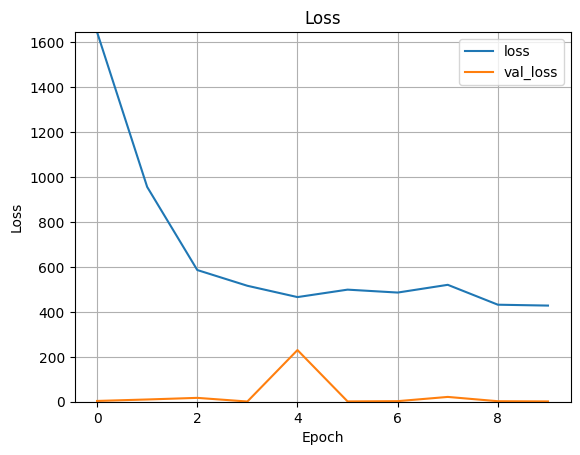

In [30]:
plot_loss(history)

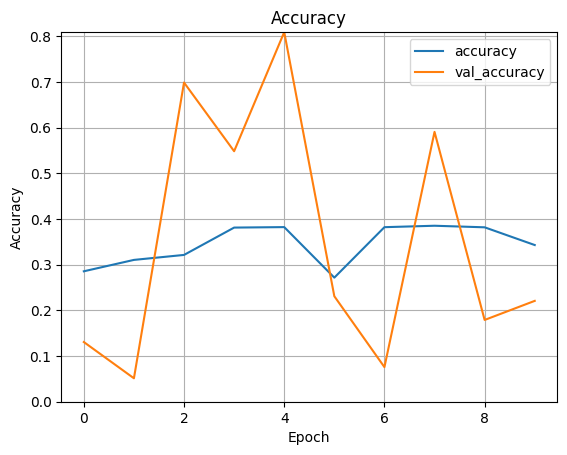

In [31]:
plot_accuracy(history)

In [32]:
predicted_result = cnn_model.predict([images_mini_t, street_mini_t])
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

66/66 [==============================] - 38s 552ms/step
macro f1:  0.04740046031335769
f1 by class:  [0.20916442 0.26484018 0.         0.         0.         0.
 0.         0.         0.         0.        ]
